In [1]:
import mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm

from scipy import signal
from scipy.io import wavfile
from scipy.stats import pearsonr, zscore
from mne_bids import BIDSPath
from functools import partial
from nilearn.plotting import plot_markers

import torch
from torch import nn
import torchaudio
from transformers import WhisperProcessor, WhisperModel, AutoFeatureExtractor, AutoProcessor

/home/matteoc/miniconda3/envs/speech-meg/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [16]:
device = torch.device("cuda:5" if torch.cuda.is_available() else "cpu")

model = WhisperModel.from_pretrained("openai/whisper-base")
feature_extractor = AutoFeatureExtractor.from_pretrained("openai/whisper-base")
processor = AutoProcessor.from_pretrained("openai/whisper-base")
model.eval()

/home/matteoc/miniconda3/envs/speech-meg/lib/python3.9/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


WhisperModel(
  (encoder): WhisperEncoder(
    (conv1): Conv1d(80, 512, kernel_size=(3,), stride=(1,), padding=(1,))
    (conv2): Conv1d(512, 512, kernel_size=(3,), stride=(2,), padding=(1,))
    (embed_positions): Embedding(1500, 512)
    (layers): ModuleList(
      (0-5): 6 x WhisperEncoderLayer(
        (self_attn): WhisperAttention(
          (k_proj): Linear(in_features=512, out_features=512, bias=False)
          (v_proj): Linear(in_features=512, out_features=512, bias=True)
          (q_proj): Linear(in_features=512, out_features=512, bias=True)
          (out_proj): Linear(in_features=512, out_features=512, bias=True)
        )
        (self_attn_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (activation_fn): GELUActivation()
        (fc1): Linear(in_features=512, out_features=2048, bias=True)
        (fc2): Linear(in_features=2048, out_features=512, bias=True)
        (final_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      )


In [2]:
# PARAMS

base_path = "/srv/nfs-data/sisko"
bids_root = base_path + "/storage/ECoG_podcast/ds005574-1.0.2" 
subject = '03'
func = partial(zscore, axis=1)
ecog_sr = 512
ecog_sr_down = 32
whisper_sr = 16000
pre_stimulus = 2.0
pre_audio = 0.2

## Get Data

In [4]:
def preprocess_raw_audio(audio_wave, fs):

    if audio_wave.ndim > 1:
        audio_wave = audio_wave[:, 0]

    audio_wave = audio_wave.astype(np.float32)
    # audio_wave = audio_wave / np.max(np.abs(audio_wave))

    return audio_wave

In [5]:
audio_path = f"{bids_root}/stimuli/podcast.wav"

audio_sf, audio_wave = wavfile.read(audio_path)
audio_wave_clean = preprocess_raw_audio(audio_wave, audio_sf)

/tmp/ipykernel_844534/2770458045.py:3: WavFileWarning: Chunk (non-data) not understood, skipping it.
  audio_sf, audio_wave = wavfile.read(audio_path)


In [8]:
file_path = BIDSPath(root=bids_root+"/derivatives/ecogprep",
                     subject=subject,
                     task="podcast",
                     datatype="ieeg",
                     description="highgamma",
                     suffix="ieeg",
                     extension="fif")

In [9]:
transcript_path = f"{bids_root}/stimuli/podcast_transcript.csv"

df = pd.read_csv(transcript_path)
df.dropna(subset=['start'], inplace=True)
df.sort_values("start", inplace=True)
events = np.zeros((len(df), 3))
events[:, 0] = df.start

In [17]:
download_audio = False

def get_stimuli_and_brain(file_path, audio_wave_clean, audio_sf, df, events, 
                          tmax=2.0, pre_audio=0.5, pre_stimulus=0.2,
                          model=None, processor=None, whisper_sr=16000,
                          device=device):
    
    model = model.to(device)

    raw = mne.io.read_raw_fif(file_path, verbose=False)
    # picks = mne.pick_channels_regexp(raw.ch_names, "LG[AB]*")
    # raw = raw.pick(picks)
    raw.load_data()
    raw = raw.apply_function(func, channel_wise=False, verbose=False)

    epochs = mne.Epochs(
        raw,
        (events * raw.info['sfreq']).astype(int),
        tmin=-pre_stimulus,
        tmax=tmax,
        baseline=None,
        proj=False,
        event_id=None,
        preload=True,
        event_repeated="merge",
        verbose=False
    )
    good_idx = epochs.selection
    print(f"Epochs object has a shape of: {epochs._data.shape}")
    epochs = epochs.resample(sfreq=ecog_sr_down, npad='auto', method='fft', window='hamming')
    epochs_snippet = epochs._data
    print(f"Epochs object after down-sampling has a shape of: {epochs_snippet.shape}")

    if download_audio:
        audio_snip_whisper = []
        for idx, row in tqdm.tqdm(enumerate(good_idx)):
            row = df.iloc[idx]
            start_sample = int((row['start']) * audio_sf) 
            end_sample = start_sample + int(tmax * audio_sf)
            snippet = audio_wave_clean[start_sample - int(pre_audio * audio_sf):end_sample]
            if len(snippet) < int(tmax * audio_sf):
                padding_len = int(tmax * audio_sf) - len(snippet)
                snippet = np.pad(snippet, (0, padding_len), mode='constant')
            snippet = torchaudio.transforms.Resample(audio_sf, whisper_sr)(torch.tensor(snippet).float())
            inputs = processor(snippet.squeeze(0), sampling_rate=whisper_sr, return_tensors="pt")
            input_features = inputs['input_features'].to(device)
            with torch.no_grad():
                outputs = model.encoder(input_features=input_features)
                hidden_states = outputs.last_hidden_state[:,:int(50*(tmax+pre_audio))]
                # hidden_states = hidden_states[:,::2]   # sort of downsampling
                audio_snip_whisper.append(hidden_states.squeeze(0).cpu())
        audio_snip_whisper = torch.stack(audio_snip_whisper, dim=0)
    else:
        audio_snip_whisper = torch.load(f"{base_path}/matteoc/podcast/audio_2_2_sec.pt")
    print(f"Audio snippets after processing have a shape of: {audio_snip_whisper.shape}")

    return epochs_snippet, audio_snip_whisper

In [18]:
brain_data, audio_data = get_stimuli_and_brain(file_path, audio_wave_clean, audio_sf, df, events, 
                                               model=model, processor=processor, pre_stimulus=pre_stimulus, pre_audio=pre_audio)

Reading 0 ... 921599  =      0.000 ...  1799.998 secs...


Epochs object has a shape of: (5130, 235, 2049)
Epochs object after down-sampling has a shape of: (5130, 235, 128)
Audio snippets after processing have a shape of: torch.Size([5130, 110, 512])


In [23]:
brain_data.mean(), brain_data.std(), audio_data.mean(), audio_data.std()

(0.0030936881650309098, 0.6971891213539375, tensor(-0.0209), tensor(1.2177))

## Autoregressive

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SoftMappingGRUSeq(nn.Module):
    def __init__(self, input_dim=512, hidden_dim=128, time_out=282, output_channels=235):
        super().__init__()
        self.encoder_gru = nn.GRU(input_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.time_queries = nn.Parameter(torch.randn(time_out, hidden_dim * 2))  # (time_out, d)
        self.attn_proj = nn.Linear(hidden_dim * 2, hidden_dim * 2)  # to match key dim
        self.output_proj = nn.Linear(hidden_dim * 2, output_channels)

    def forward(self, x):  # x: (batch, time_in, 512)
        h, _ = self.encoder_gru(x)  # (batch, time_in, d*2)

        # Compute attention: time_out queries → weighted sum over time_in
        q = self.time_queries.unsqueeze(0).expand(x.size(0), -1, -1)  # (batch, time_out, d*2)
        k = self.attn_proj(h)  # (batch, time_in, d*2)

        attn_weights = torch.matmul(q, k.transpose(1, 2))  # (batch, time_out, time_in)
        attn_weights = F.softmax(attn_weights, dim=-1)

        context = torch.bmm(attn_weights, h)  # (batch, time_out, d*2)
        out = self.output_proj(context)       # (batch, time_out, channels)
        return out.permute(0, 2, 1), attn_weights  # (batch, channels, time_out), (batch, time_out, time_in)


In [58]:
class GRUStim2Brain(nn.Module):
    def __init__(self, input_dim=512, hidden_dim=128, output_channels=235, time_out=282):
        super().__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.linear = nn.Linear(hidden_dim * 2, output_channels)
        self.temporal_upsample = nn.Upsample(size=time_out, mode='linear', align_corners=True)

    def forward(self, x):  # x: (batch, time_in, 512)
        out, _ = self.gru(x)  # (batch, time_in, hidden_dim*2)
        out = self.temporal_upsample(out.permute(0, 2, 1)).permute(0, 2, 1)  # (batch, time_out, hidden_dim*2)
        out = self.linear(out)  # (batch, time_out, channels)
        return out.permute(0, 2, 1)  # (batch, channels, time_out)

## Model

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.pe = pe.unsqueeze(0)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)].to(x.device)

class AttentiveStim2BrainNet(nn.Module):
    def __init__(self, input_dim=512, output_channels=235, time_in=250, time_out=282, d_model=256, nhead=4, num_layers=4):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, d_model)
        self.pos_enc = PositionalEncoding(d_model, max_len=time_in)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
        # self.norm = nn.LayerNorm(d_model)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.temporal_upsample = nn.Upsample(size=time_out, mode='linear', align_corners=True)

        self.mh_attention = nn.MultiheadAttention(embed_dim=d_model, num_heads=nhead, batch_first=True)
        self.output_proj = nn.Linear(d_model, output_channels)

    def forward(self, x):   # x: (batch, time_in, input_dim=512)
        x = self.input_proj(x)                           # (batch, time_in, d_model)
        x = self.pos_enc(x)                             
        x_encoded = self.encoder(x)                             
        x_target = self.temporal_upsample(x_encoded.permute(0, 2, 1)).permute(0, 2, 1)   # (batch, time_out, d_model)
        x_attn, attn_weights = self.mh_attention(query=x_target, key=x_encoded, value=x_encoded)  # (batch, time_out, d_model)    
        # x = self.norm(x_attn)
        x = self.output_proj(x_attn)                    # (batch, time_out, output_channels)
        return x.permute(0, 2, 1), attn_weights                       # (batch, output_channels, time_out)
    
    



In [22]:
brain_timep = brain_data.shape[-1]
brain_channels = brain_data.shape[1]
audio_timep = audio_data.shape[1]

In [24]:
from torch.utils.data import TensorDataset, DataLoader, Subset
from sklearn.preprocessing import StandardScaler
import torch


n = brain_data.shape[0]
train_size = int(0.8 * n)
val_size = int(0.1 * n)
test_size = n - train_size - val_size

indices = list(range(n))
train_idx = indices[:train_size]
val_idx   = indices[train_size:train_size+val_size]
test_idx  = indices[train_size+val_size:]

# Applica StandardScaler SOLO sui dati cerebrali di training
brain_np = brain_data.reshape(n, -1)  # shape: (samples, features)
scaler = StandardScaler()
brain_train_scaled = scaler.fit_transform(brain_np[train_idx])  # fit solo sul training
brain_val_scaled   = scaler.transform(brain_np[val_idx])
brain_test_scaled  = scaler.transform(brain_np[test_idx])

brain_train_std = torch.tensor(brain_train_scaled, dtype=torch.float32).reshape(-1, brain_channels, brain_timep)
brain_val_std   = torch.tensor(brain_val_scaled,   dtype=torch.float32).reshape(-1, brain_channels, brain_timep)
brain_test_std  = torch.tensor(brain_test_scaled,  dtype=torch.float32).reshape(-1, brain_channels, brain_timep)

stimuli = audio_data.to(torch.float32)
stimuli_train = stimuli[train_idx]
stimuli_val   = stimuli[val_idx]
stimuli_test  = stimuli[test_idx]

train_ds = TensorDataset(stimuli_train, brain_train_std)
val_ds   = TensorDataset(stimuli_val, brain_val_std)
test_ds  = TensorDataset(stimuli_test, brain_test_std)

batch_size = 32
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False)


In [25]:
import random

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # se usi GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [26]:
from torch import nn, optim
from tqdm import tqdm

set_seed(42)
# model = AttentiveStim2BrainNet(d_model=128, nhead=4, num_layers=2, time_in=audio_timep, time_out=brain_timep, output_channels=brain_channels).to(device)
model = SoftMappingGRUSeq(input_dim=512, hidden_dim=128, time_out=brain_timep, output_channels=brain_channels).to(device)
mse_loss = nn.MSELoss()

mse_perc = 0.2
cl_perc = 0.8

def pearson_loss(pred, target, eps=1e-8):
    pred = pred - pred.mean(dim=-1, keepdim=True)
    target = target - target.mean(dim=-1, keepdim=True)
    corr_num = (pred * target).sum(dim=-1)
    corr_den = (pred.norm(dim=-1) * target.norm(dim=-1)).clamp(min=eps)
    corr = corr_num / corr_den
    return 1 - corr.mean()

def contrastive_loss(pred, target, tau=0.05):
    target = target.reshape(target.shape[0], -1)
    pred = pred.reshape(pred.shape[0], -1)   
    pred = F.normalize(pred, dim=1)   # (batch, 1)
    target = F.normalize(target, dim=1)
    sim_matrix = torch.mm(pred, target.T)   # (batch, batch)
    sim_matrix = sim_matrix / tau
    loss = -torch.log(torch.exp(torch.diag(sim_matrix)) / sim_matrix.exp().sum(dim=1))
    return loss.mean()

optimizer = optim.AdamW(model.parameters(), lr=1e-4, betas=(0.9, 0.99), weight_decay=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5)

# Training loop
num_epochs = 30
best_val_loss = float('inf')

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for x, y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        optimizer.zero_grad()
        x, y = x.to(device), y.to(device)
        y_pred, _ = model(x)
        loss = mse_perc * mse_loss(y_pred, y.float()) + cl_perc * contrastive_loss(y_pred, y.float())
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * x.size(0)

    train_loss /= len(train_loader.dataset)

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            y_pred, _ = model(x)
            val_loss += (mse_perc * mse_loss(y_pred, y) + cl_perc * contrastive_loss(y_pred, y)) * x.size(0)
    val_loss /= len(val_loader.dataset)
    scheduler.step(val_loss)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # Salva il modello migliore
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "/home/matteoc/ecog-speech/best_model_CL2.pt")


Epoch 1/30:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch 1/30: 100%|██████████| 129/129 [00:01<00:00, 107.23it/s]


Epoch 1, Train Loss: 2.9363, Val Loss: 2.9488


Epoch 2/30: 100%|██████████| 129/129 [00:01<00:00, 123.54it/s]


Epoch 2, Train Loss: 2.7094, Val Loss: 2.8723


Epoch 3/30: 100%|██████████| 129/129 [00:00<00:00, 145.16it/s]


Epoch 3, Train Loss: 2.5131, Val Loss: 2.7873


Epoch 4/30: 100%|██████████| 129/129 [00:00<00:00, 158.38it/s]


Epoch 4, Train Loss: 2.3718, Val Loss: 2.7262


Epoch 5/30: 100%|██████████| 129/129 [00:00<00:00, 158.84it/s]


Epoch 5, Train Loss: 2.2696, Val Loss: 2.6892


Epoch 6/30: 100%|██████████| 129/129 [00:00<00:00, 165.76it/s]


Epoch 6, Train Loss: 2.1971, Val Loss: 2.6604


Epoch 7/30: 100%|██████████| 129/129 [00:00<00:00, 165.71it/s]


Epoch 7, Train Loss: 2.1430, Val Loss: 2.6432


Epoch 8/30: 100%|██████████| 129/129 [00:00<00:00, 163.62it/s]


Epoch 8, Train Loss: 2.0900, Val Loss: 2.6211


Epoch 9/30: 100%|██████████| 129/129 [00:00<00:00, 164.81it/s]


Epoch 9, Train Loss: 2.0476, Val Loss: 2.6221


Epoch 10/30: 100%|██████████| 129/129 [00:00<00:00, 175.50it/s]


Epoch 10, Train Loss: 2.0141, Val Loss: 2.6095


Epoch 11/30: 100%|██████████| 129/129 [00:00<00:00, 170.40it/s]


Epoch 11, Train Loss: 1.9748, Val Loss: 2.6113


Epoch 12/30: 100%|██████████| 129/129 [00:00<00:00, 171.43it/s]


Epoch 12, Train Loss: 1.9457, Val Loss: 2.5937


Epoch 13/30: 100%|██████████| 129/129 [00:00<00:00, 170.46it/s]


Epoch 13, Train Loss: 1.9181, Val Loss: 2.6042


Epoch 14/30: 100%|██████████| 129/129 [00:00<00:00, 174.31it/s]


Epoch 14, Train Loss: 1.8878, Val Loss: 2.5932


Epoch 15/30: 100%|██████████| 129/129 [00:00<00:00, 161.66it/s]


Epoch 15, Train Loss: 1.8647, Val Loss: 2.5954


Epoch 16/30: 100%|██████████| 129/129 [00:00<00:00, 174.35it/s]


Epoch 16, Train Loss: 1.8424, Val Loss: 2.5930


Epoch 17/30: 100%|██████████| 129/129 [00:00<00:00, 168.48it/s]


Epoch 17, Train Loss: 1.8169, Val Loss: 2.5782


Epoch 18/30: 100%|██████████| 129/129 [00:00<00:00, 169.18it/s]


Epoch 18, Train Loss: 1.7945, Val Loss: 2.5895


Epoch 19/30: 100%|██████████| 129/129 [00:00<00:00, 168.47it/s]


Epoch 19, Train Loss: 1.7718, Val Loss: 2.5844


Epoch 20/30: 100%|██████████| 129/129 [00:00<00:00, 167.10it/s]


Epoch 20, Train Loss: 1.7564, Val Loss: 2.5793


Epoch 21/30: 100%|██████████| 129/129 [00:00<00:00, 164.68it/s]


Epoch 21, Train Loss: 1.7319, Val Loss: 2.5849


Epoch 22/30: 100%|██████████| 129/129 [00:00<00:00, 168.27it/s]


Epoch 22, Train Loss: 1.7138, Val Loss: 2.5999


Epoch 23/30: 100%|██████████| 129/129 [00:00<00:00, 170.81it/s]


Epoch 23, Train Loss: 1.6970, Val Loss: 2.5910


Epoch 24/30: 100%|██████████| 129/129 [00:00<00:00, 166.85it/s]


Epoch 24, Train Loss: 1.6582, Val Loss: 2.5787


Epoch 25/30: 100%|██████████| 129/129 [00:00<00:00, 178.41it/s]


Epoch 25, Train Loss: 1.6517, Val Loss: 2.5837


Epoch 26/30: 100%|██████████| 129/129 [00:00<00:00, 169.22it/s]


Epoch 26, Train Loss: 1.6485, Val Loss: 2.5793


Epoch 27/30: 100%|██████████| 129/129 [00:00<00:00, 170.31it/s]


Epoch 27, Train Loss: 1.6471, Val Loss: 2.5808


Epoch 28/30: 100%|██████████| 129/129 [00:00<00:00, 166.26it/s]


Epoch 28, Train Loss: 1.6479, Val Loss: 2.5856


Epoch 29/30: 100%|██████████| 129/129 [00:00<00:00, 174.05it/s]


Epoch 29, Train Loss: 1.6403, Val Loss: 2.5845


Epoch 30/30: 100%|██████████| 129/129 [00:00<00:00, 168.72it/s]


Epoch 30, Train Loss: 1.6390, Val Loss: 2.5858


In [27]:
# Valutazione finale su test set
model.load_state_dict(torch.load("/home/matteoc/ecog-speech/best_model_CL2.pt"))
model.eval()
test_loss = 0
y_pred_all = []
y_true_all = []
attn_pred_all = []
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        y_pred, attn_pred = model(x)
        attn_pred_all.append(attn_pred.cpu())
        y_pred_all.append(y_pred)
        y_true_all.append(y.cpu())
        test_loss += (mse_perc * mse_loss(y_pred, y) + cl_perc * contrastive_loss(y_pred, y)) * x.size(0)
y_pred_all = torch.cat(y_pred_all, dim=0)
y_true_all = torch.cat(y_true_all, dim=0)
attn_pred_all = torch.cat(attn_pred_all, dim=0)
test_loss /= len(test_loader.dataset)
print(f"Test Loss: {test_loss:.4f}")

Test Loss: 2.4480


In [28]:
attn_pred_all.shape

torch.Size([513, 128, 110])

<Axes: >

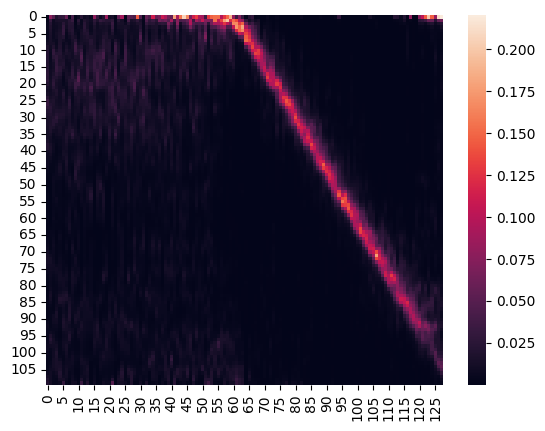

In [30]:
import seaborn as sns

sns.heatmap(attn_pred_all.mean(dim=0).T.cpu().numpy(), cbar=True)
# plt.plot(attn_pred_all.mean(dim=0).cpu().numpy())

## Cross Val

In [198]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch import nn, optim
import torch.nn.functional as F
from tqdm import tqdm
import numpy as np

# outer_cv = KFold(n_splits=4, shuffle=True, random_state=42)
outer_cv = KFold(n_splits=4, shuffle=False)
all_corrs, all_attn = [], []

brain_np = brain_data.reshape(5130, -1)
# audio_np = audio_data.cpu().numpy()

for fold_idx, (train_idx, test_idx) in tqdm(enumerate(outer_cv.split(brain_data))):
    print(f"\n--- Fold {fold_idx + 1} ---")

    scaler = StandardScaler()
    brain_train = scaler.fit_transform(brain_np[train_idx])
    brain_test = scaler.transform(brain_np[test_idx])

    brain_train = torch.tensor(brain_train, dtype=torch.float32).reshape(-1, brain_channels, brain_timep)
    brain_test = torch.tensor(brain_test, dtype=torch.float32).reshape(-1, brain_channels, brain_timep)

    stimuli_train = audio_data[train_idx]
    stimuli_test = audio_data[test_idx]

    train_dataset = TensorDataset(stimuli_train.to(device), brain_train.to(device))
    test_dataset = TensorDataset(stimuli_test.to(device), brain_test.to(device))

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # Model
    set_seed(42)
    # model = AttentiveStim2BrainNet(
    #     d_model=128, nhead=2, num_layers=2,
    #     time_in=audio_timep, time_out=brain_timep,
    #     output_channels=brain_channels
    # ).to(device)
    model = SoftMappingGRUSeq(input_dim=512, hidden_dim=128, time_out=brain_timep, output_channels=brain_channels).to(device)

    mse_loss = nn.MSELoss()

    def contrastive_loss(pred, target, tau=0.05):
        target = target.reshape(target.shape[0], -1)
        pred = pred.reshape(pred.shape[0], -1)
        pred = F.normalize(pred, dim=1)
        target = F.normalize(target, dim=1)
        sim_matrix = torch.mm(pred, target.T) / tau
        loss = -torch.log(torch.exp(torch.diag(sim_matrix)) / sim_matrix.exp().sum(dim=1))
        return loss.mean()

    optimizer = optim.AdamW(model.parameters(), lr=1e-4, betas=(0.9, 0.99), weight_decay=1e-3)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5)

    best_loss = float('inf')
    for epoch in range(35):
        model.train()
        total_loss = 0
        for x, y in train_loader:
            optimizer.zero_grad()
            x, y = x.to(device), y.to(device)
            y_pred, _ = model(x)
            loss = 0.2 * mse_loss(y_pred, y) + 0.8 * contrastive_loss(y_pred, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * x.size(0)
        total_loss /= len(train_loader.dataset)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for x, y in test_loader:
                x, y = x.to(device), y.to(device)
                y_pred, _ = model(x)
                loss = 0.2 * mse_loss(y_pred, y) + 0.8 * contrastive_loss(y_pred, y)
                val_loss += loss.item() * x.size(0)
        val_loss /= len(test_loader.dataset)
        scheduler.step(val_loss)

        print(f"Epoch {epoch+1} - Train Loss: {total_loss:.4f} | Test Loss: {val_loss:.4f}")

        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(model.state_dict(), f"/home/matteoc/ecog-speech/best_model_fold{fold_idx+1}.pt")

    # Valutazione finale (ad es. Pearson corr)
    model.load_state_dict(torch.load(f"/home/matteoc/ecog-speech/best_model_fold{fold_idx+1}.pt"))
    model.eval()
    preds, targets, attn_values = [], [], []
    with torch.no_grad():
        for x, y in test_loader:
            y, x = y.to(device), x.to(device)
            y_pred, attn_pred = model(x)
            preds.append(y_pred.cpu().numpy())
            targets.append(y.cpu().numpy())
            attn_values.append(attn_pred.cpu().numpy())
    preds = np.concatenate(preds, axis=0)
    targets = np.concatenate(targets, axis=0)
    attn_values = np.concatenate(attn_values, axis=0)

    # corrs = np.array([np.corrcoef(p, t)[0, 1] for p, t in zip(preds.T, targets.T)]).reshape(brain_channels, brain_timep)
    corrs = np.zeros((brain_channels, brain_timep))
    for ch in range(brain_channels):
        for t in range(brain_timep):
            corrs[ch, t] = np.corrcoef(preds[:, ch, t], targets[:, ch, t])[0, 1]
    all_corrs.append(corrs)
    all_attn.append(attn_values)

# Risultati finali
all_corrs = np.stack(all_corrs)
all_attn = np.concatenate(all_attn, axis=0)
print(f"\nFinal mean correlation across folds: {all_corrs.mean():.4f}")


0it [00:00, ?it/s]


--- Fold 1 ---
Epoch 1 - Train Loss: 2.9391 | Test Loss: 2.9464
Epoch 2 - Train Loss: 2.7389 | Test Loss: 2.8778
Epoch 3 - Train Loss: 2.5773 | Test Loss: 2.7994
Epoch 4 - Train Loss: 2.4430 | Test Loss: 2.7078
Epoch 5 - Train Loss: 2.3347 | Test Loss: 2.6385
Epoch 6 - Train Loss: 2.2545 | Test Loss: 2.5878
Epoch 7 - Train Loss: 2.1901 | Test Loss: 2.5654
Epoch 8 - Train Loss: 2.1407 | Test Loss: 2.5394
Epoch 9 - Train Loss: 2.0910 | Test Loss: 2.5214
Epoch 10 - Train Loss: 2.0551 | Test Loss: 2.5096
Epoch 11 - Train Loss: 2.0200 | Test Loss: 2.4964
Epoch 12 - Train Loss: 1.9841 | Test Loss: 2.4937
Epoch 13 - Train Loss: 1.9513 | Test Loss: 2.4857
Epoch 14 - Train Loss: 1.9270 | Test Loss: 2.4828
Epoch 15 - Train Loss: 1.8964 | Test Loss: 2.4763
Epoch 16 - Train Loss: 1.8717 | Test Loss: 2.4766
Epoch 17 - Train Loss: 1.8452 | Test Loss: 2.4751
Epoch 18 - Train Loss: 1.8226 | Test Loss: 2.4754
Epoch 19 - Train Loss: 1.8040 | Test Loss: 2.4737
Epoch 20 - Train Loss: 1.7799 | Test Loss: 

1it [00:18, 18.74s/it]


--- Fold 2 ---
Epoch 1 - Train Loss: 2.9344 | Test Loss: 2.9504
Epoch 2 - Train Loss: 2.7214 | Test Loss: 2.8711
Epoch 3 - Train Loss: 2.5465 | Test Loss: 2.7825
Epoch 4 - Train Loss: 2.4078 | Test Loss: 2.7087
Epoch 5 - Train Loss: 2.3042 | Test Loss: 2.6528
Epoch 6 - Train Loss: 2.2245 | Test Loss: 2.6252
Epoch 7 - Train Loss: 2.1668 | Test Loss: 2.5993
Epoch 8 - Train Loss: 2.1193 | Test Loss: 2.5777
Epoch 9 - Train Loss: 2.0729 | Test Loss: 2.5574
Epoch 10 - Train Loss: 2.0369 | Test Loss: 2.5489
Epoch 11 - Train Loss: 2.0039 | Test Loss: 2.5404
Epoch 12 - Train Loss: 1.9717 | Test Loss: 2.5293
Epoch 13 - Train Loss: 1.9378 | Test Loss: 2.5271
Epoch 14 - Train Loss: 1.9083 | Test Loss: 2.5276
Epoch 15 - Train Loss: 1.8823 | Test Loss: 2.5196
Epoch 16 - Train Loss: 1.8546 | Test Loss: 2.5209
Epoch 17 - Train Loss: 1.8324 | Test Loss: 2.5256
Epoch 18 - Train Loss: 1.8116 | Test Loss: 2.5176
Epoch 19 - Train Loss: 1.7906 | Test Loss: 2.5214
Epoch 20 - Train Loss: 1.7662 | Test Loss: 

2it [00:39, 19.89s/it]


--- Fold 3 ---
Epoch 1 - Train Loss: 2.9419 | Test Loss: 2.9620
Epoch 2 - Train Loss: 2.7485 | Test Loss: 2.9073
Epoch 3 - Train Loss: 2.5868 | Test Loss: 2.8301
Epoch 4 - Train Loss: 2.4447 | Test Loss: 2.7508
Epoch 5 - Train Loss: 2.3333 | Test Loss: 2.6925
Epoch 6 - Train Loss: 2.2472 | Test Loss: 2.6645
Epoch 7 - Train Loss: 2.1831 | Test Loss: 2.6297
Epoch 8 - Train Loss: 2.1294 | Test Loss: 2.6152
Epoch 9 - Train Loss: 2.0831 | Test Loss: 2.5988
Epoch 10 - Train Loss: 2.0435 | Test Loss: 2.5853
Epoch 11 - Train Loss: 2.0035 | Test Loss: 2.5761
Epoch 12 - Train Loss: 1.9702 | Test Loss: 2.5692
Epoch 13 - Train Loss: 1.9396 | Test Loss: 2.5807
Epoch 14 - Train Loss: 1.9088 | Test Loss: 2.5733
Epoch 15 - Train Loss: 1.8835 | Test Loss: 2.5674
Epoch 16 - Train Loss: 1.8565 | Test Loss: 2.5562
Epoch 17 - Train Loss: 1.8343 | Test Loss: 2.5497
Epoch 18 - Train Loss: 1.8079 | Test Loss: 2.5595
Epoch 19 - Train Loss: 1.7898 | Test Loss: 2.5568
Epoch 20 - Train Loss: 1.7613 | Test Loss: 

3it [00:59, 19.87s/it]


--- Fold 4 ---
Epoch 1 - Train Loss: 2.9429 | Test Loss: 2.9598
Epoch 2 - Train Loss: 2.7265 | Test Loss: 2.8908
Epoch 3 - Train Loss: 2.5444 | Test Loss: 2.8119
Epoch 4 - Train Loss: 2.3977 | Test Loss: 2.7400
Epoch 5 - Train Loss: 2.2910 | Test Loss: 2.6869
Epoch 6 - Train Loss: 2.2076 | Test Loss: 2.6548
Epoch 7 - Train Loss: 2.1486 | Test Loss: 2.6241
Epoch 8 - Train Loss: 2.0977 | Test Loss: 2.6057
Epoch 9 - Train Loss: 2.0517 | Test Loss: 2.5907
Epoch 10 - Train Loss: 2.0147 | Test Loss: 2.5865
Epoch 11 - Train Loss: 1.9800 | Test Loss: 2.5705
Epoch 12 - Train Loss: 1.9454 | Test Loss: 2.5655
Epoch 13 - Train Loss: 1.9152 | Test Loss: 2.5689
Epoch 14 - Train Loss: 1.8879 | Test Loss: 2.5600
Epoch 15 - Train Loss: 1.8625 | Test Loss: 2.5620
Epoch 16 - Train Loss: 1.8398 | Test Loss: 2.5502
Epoch 17 - Train Loss: 1.8182 | Test Loss: 2.5432
Epoch 18 - Train Loss: 1.7909 | Test Loss: 2.5462
Epoch 19 - Train Loss: 1.7712 | Test Loss: 2.5426
Epoch 20 - Train Loss: 1.7467 | Test Loss: 

4it [01:19, 19.87s/it]


Final mean correlation across folds: 0.0231


<Axes: >

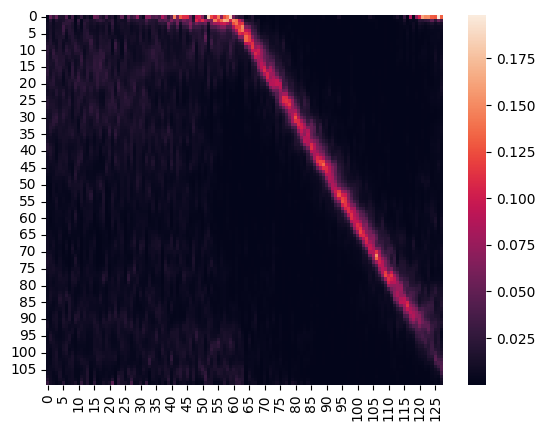

In [203]:
import seaborn as sns

sns.heatmap(all_attn.mean(axis=0).T, cbar=True)

In [200]:
all_corrs.shape

(4, 235, 128)

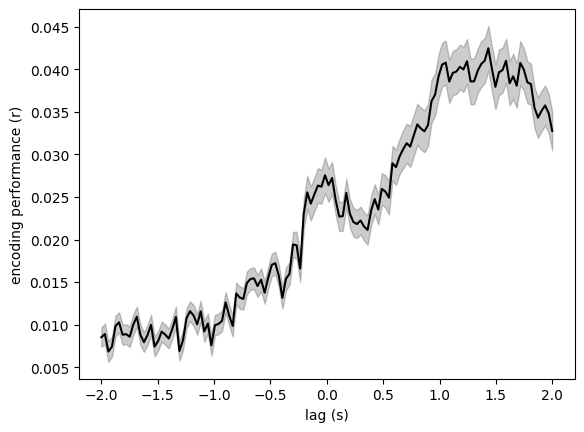

In [201]:
lags = np.linspace(-pre_stimulus, 2, brain_timep) 
mean = all_corrs.mean((0, 1))
# std = correlations_time.std((0)) 
std = all_corrs.std((0, 1)) / np.sqrt(np.product(all_corrs.shape[:2]))

fig, ax = plt.subplots()
ax.plot(lags, mean, color='black')
ax.fill_between(lags, mean - std, mean + std, alpha=0.2, color='black')
ax.set_xlabel("lag (s)")
ax.set_ylabel("encoding performance (r)")
# ax.axvline(0, c=(.9, .9, .9), ls="--")
# ax.axhline(0, c=(.9, .9, .9), ls="--")
fig.show()

Coordinate matrix shape:  (235, 3)


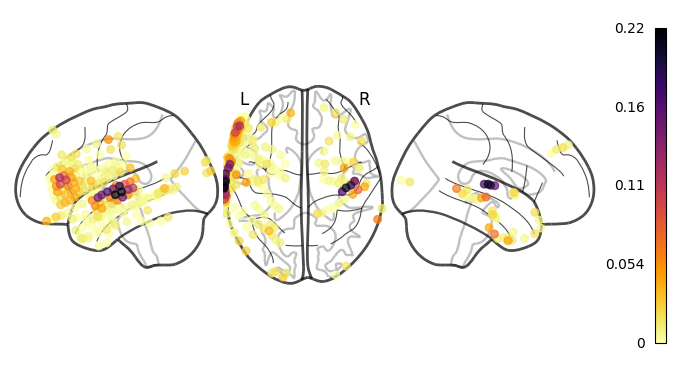

In [202]:
raw = mne.io.read_raw_fif(file_path, verbose=False)
raw.load_data(verbose=False)
raw = raw.apply_function(func, channel_wise=False, verbose=False)

ch2loc = {ch['ch_name']: ch['loc'][:3] for ch in raw.info['chs']}
coords = np.vstack([ch2loc[ch] for ch in raw.info['ch_names']])
coords *= 1000  # nilearn likes to plot in meters, not mm
print("Coordinate matrix shape: ", coords.shape)

order = all_corrs.mean((0,2)).argsort()
plot_markers(all_corrs.mean((0,2))[order], coords[order],
             node_size=30, display_mode='lzr',
             node_vmin=0, node_cmap='inferno_r', colorbar=True)
plt.show()

## Baselines

In [265]:
train_inputs, train_targets = map(torch.stack, zip(*train_ds))
val_inputs, val_targets = map(torch.stack, zip(*val_ds))
test_inputs, test_targets = map(torch.stack, zip(*test_ds))

train_inputs = train_inputs.reshape(train_inputs.shape[0], -1)
train_targets = train_targets.reshape(train_targets.shape[0], -1)
val_inputs = val_inputs.reshape(val_inputs.shape[0], -1)
val_targets = val_targets.reshape(val_targets.shape[0], -1)
test_inputs = test_inputs.reshape(test_inputs.shape[0], -1)
test_targets = test_targets.reshape(test_targets.shape[0], -1)


In [267]:
from himalaya.ridge import RidgeCV
from himalaya.kernel_ridge import KernelRidgeCV
from himalaya.backend import set_backend

vm = KernelRidgeCV(alphas=[0.1,1,10,30,50,100,1000])  

device_id = 7
backend = set_backend("torch_cuda")
X_train_F = backend.asarray(torch.tensor(train_inputs).float().to(f'cuda:{device_id}'))
Y_train_F = backend.asarray(torch.tensor(train_targets).float().to(f'cuda:{device_id}')) 
X_test_F = backend.asarray(torch.tensor(test_inputs).float().to(f'cuda:{device_id}'))     

vm.fit(X_train_F, Y_train_F)
y_pred_F = vm.predict(X_test_F).reshape(-1, brain_channels, brain_timep).cpu()

/tmp/ipykernel_493096/1225219186.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_F = backend.asarray(torch.tensor(train_inputs).float().to(f'cuda:{device_id}'))
/tmp/ipykernel_493096/1225219186.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_train_F = backend.asarray(torch.tensor(train_targets).float().to(f'cuda:{device_id}'))
/tmp/ipykernel_493096/1225219186.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test_F = backend.asarray(torch.tensor(test_inputs).float().to(f'cuda:{device_id}'))


In [268]:
y_true_all = test_targets.reshape(-1, brain_channels, brain_timep).cpu()
y_pred_all = y_pred_F

## Evaluation

In [31]:
from torchmetrics.functional import pearson_corrcoef

correlations_time = np.zeros((y_pred_all.shape[0], y_pred_all.shape[2]))
for sample in tqdm(range(y_pred_all.shape[0])):
    y_pred_sample = y_pred_all[sample, :, :]
    y_true_sample = y_true_all[sample, :, :]
    for tp in range(y_pred_all.shape[2]):
        pred = y_pred_sample[:, tp]
        target = y_true_sample[:, tp]
        corr = pearson_corrcoef(pred.cpu(), target)
        correlations_time[sample, tp] = corr.item()

100%|██████████| 513/513 [00:08<00:00, 57.77it/s]


In [32]:
correlations_mean = np.mean(correlations_time, axis=0)
correlations_std = np.std(correlations_time, axis=0)

In [33]:
correlations_mean.max(), correlations_mean.mean(), correlations_mean.min(), correlations_mean.std()

(0.08503307685660848,
 0.04208093186579216,
 0.004091368793200013,
 0.02407721694400397)

In [34]:
from torchmetrics.functional import pearson_corrcoef

correlations_channels = np.zeros((y_pred_all.shape[0], y_pred_all.shape[1]))
for sample in tqdm(range(y_pred_all.shape[0])):
    y_pred_sample = y_pred_all[sample, :, :]
    y_true_sample = y_true_all[sample, :, :]
    for channel in range(y_pred_all.shape[1]):
        pred = y_pred_sample[channel, :]
        target = y_true_sample[channel, :]
        corr = pearson_corrcoef(pred.cpu(), target)
        correlations_channels[sample, channel] = corr.item()

  2%|▏         | 12/513 [00:00<00:13, 38.48it/s]/home/matteoc/miniconda3/envs/speech-meg/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The variance of predictions or target is close to zero. This can cause instability in Pearson correlationcoefficient, leading to wrong results. Consider re-scaling the input if possible or computing using alarger dtype (currently using torch.float32).
  warnings.warn(*args, **kwargs)  # noqa: B028
100%|██████████| 513/513 [00:13<00:00, 38.92it/s]


In [35]:
correlations_channels = np.mean(correlations_channels, axis=0)

In [36]:
correlations_channels.max(), correlations_channels.mean(), correlations_channels.min(), correlations_channels.std()

(0.2719086126234204,
 0.023480777799261263,
 -0.021140964200425636,
 0.04639478827719671)

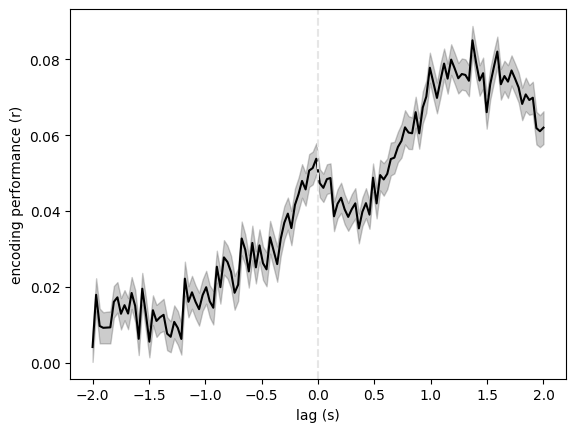

In [37]:
lags = np.linspace(-pre_stimulus, 2, brain_timep) 
mean = correlations_time.mean((0))
# std = correlations_time.std((0)) 
std = correlations_time.std((0)) / np.sqrt(np.product(correlations_time.shape[:1]))

fig, ax = plt.subplots()
ax.plot(lags, mean, color='black')
ax.fill_between(lags, mean - std, mean + std, alpha=0.2, color='black')
ax.set_xlabel("lag (s)")
ax.set_ylabel("encoding performance (r)")
ax.axvline(0, c=(.9, .9, .9), ls="--")
# ax.axhline(0, c=(.9, .9, .9), ls="--")
fig.show()

Coordinate matrix shape:  (235, 3)


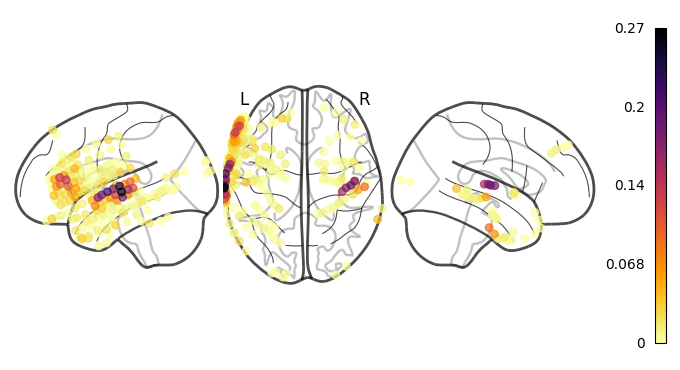

In [38]:
raw = mne.io.read_raw_fif(file_path, verbose=False)
raw.load_data(verbose=False)
raw = raw.apply_function(func, channel_wise=False, verbose=False)

ch2loc = {ch['ch_name']: ch['loc'][:3] for ch in raw.info['chs']}
coords = np.vstack([ch2loc[ch] for ch in raw.info['ch_names']])
coords *= 1000  # nilearn likes to plot in meters, not mm
print("Coordinate matrix shape: ", coords.shape)

order = correlations_channels.argsort()
plot_markers(correlations_channels[order], coords[order],
             node_size=30, display_mode='lzr',
             node_vmin=0, node_cmap='inferno_r', colorbar=True)
plt.show()